# Data exploration, selection and cleaning

In [30]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

DF=pd.read_csv("data/raw/us_equities.csv.gz")
DF.drop('Unnamed: 0', axis=1,inplace=True)  # the first column contains the line number

### 1. Manual exploration of data

In [2]:
print(DF.shape)   # dimensions
print(DF.head())





(16291, 1053)
   ^GSPC  GE  IBM  DIS  BA  CAT  AA  HPQ  DD  KO  ...  CTX  CTR  DYN  AIB  \
0  16.66 NaN  NaN  NaN NaN  NaN NaN  NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
1  16.85 NaN  NaN  NaN NaN  NaN NaN  NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
2  16.93 NaN  NaN  NaN NaN  NaN NaN  NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
3  16.98 NaN  NaN  NaN NaN  NaN NaN  NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
4  17.08 NaN  NaN  NaN NaN  NaN NaN  NaN NaN NaN  ...  NaN  NaN  NaN  NaN   

   PCU  KIM  SFN  AMR  TCO   S  
0  NaN  NaN  NaN  NaN  NaN NaN  
1  NaN  NaN  NaN  NaN  NaN NaN  
2  NaN  NaN  NaN  NaN  NaN NaN  
3  NaN  NaN  NaN  NaN  NaN NaN  
4  NaN  NaN  NaN  NaN  NaN NaN  

[5 rows x 1053 columns]


Thus columns names are asset symbols. ^GSPC is the S&P500 index, GE is General Electric, IBM is IBM, CAT Caterpillar. So it seems that this really is a US equities dataset. The data itself is probably a price. Dates are missing. There are also many missing values. Let us see how much data is missing as a function of time:

Text(0, 0.5, 'log ^GSPC')

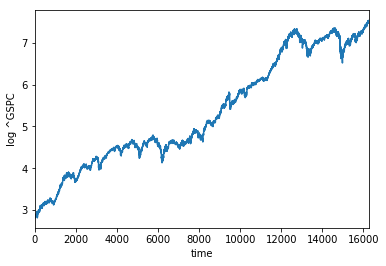

In [3]:
np.log(DF["^GSPC"]).plot()  
plt.xlabel("time")
plt.ylabel("log ^GSPC")

This looks very much like the real ^GSPC, and dates include 2008.

Text(0, 0.5, 'log-returns ^GSPC')

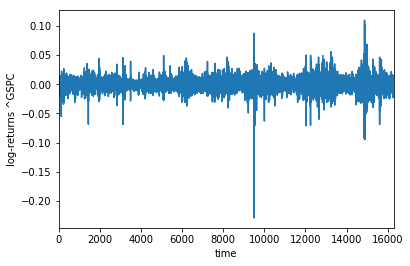

In [4]:
np.log(DF["^GSPC"]).diff().plot()
plt.xlabel("time")
plt.ylabel("log-returns ^GSPC")

### 2. Missing data

/home/damien/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


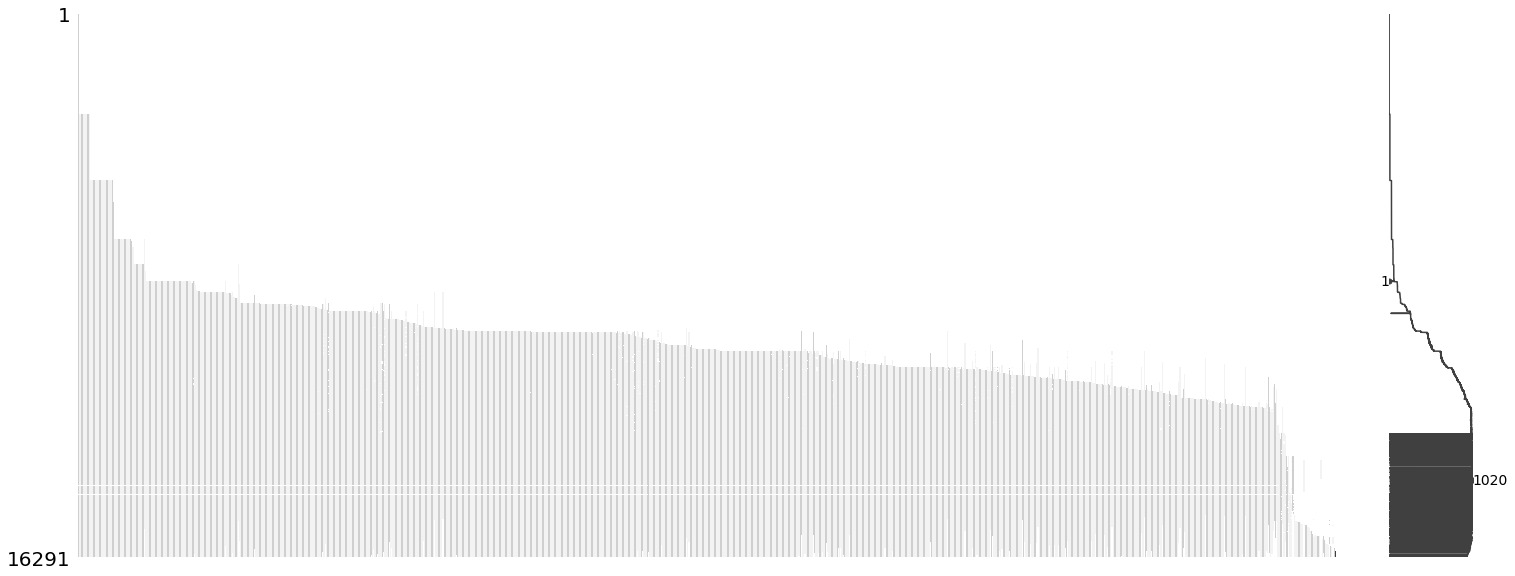

In [5]:
import missingno as msno
msno.matrix(DF)

In [43]:
DF[DF["^GSPC"].isnull()].notnull().sum()>0

^GSPC    False
GE       False
IBM      False
DIS      False
BA       False
         ...  
KIM      False
SFN      False
AMR       True
TCO      False
S        False
Length: 1053, dtype: bool

Text(0, 0.5, 'number of NA cols')

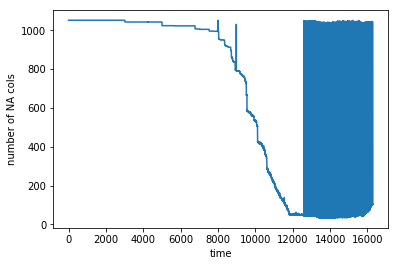

In [6]:
missingDataPerLine = DF.isnull().sum(axis=1) 

plt.plot(missingDataPerLine)
plt.xlabel("time")
plt.ylabel("number of NA cols")



### 3. Remove unwanted lines and columns

In [7]:
#when ^GSPC is NA
special_lines=DF["^GSPC"].isnull()

#what is not NA when ^GSPC is NA
DF[special_lines].notnull()

#sum by column
is_asset_special=DF[special_lines].notnull().sum(axis=0)>0

#special assets are then easily obtained
special_assets=DF.columns[is_asset_special]
print(special_assets)

Index(['BAX', 'TAP', 'WRB', 'AVY', 'ATO', 'AJG', 'AIT', 'B', 'BMI', 'AZZ',
       'CAS', 'ARL', 'CBT', 'BCE', 'GAS', 'AEM', 'BEN', 'ABX', 'AM', 'BBY',
       'PRX', 'BRC', 'AEG', 'SUN', 'SOV', 'SGR', 'LIZ', 'ABK', 'ID', 'TKS',
       'BMT', 'TBL', 'SBG', 'SEL', 'PPD', 'TPP', 'ARA', 'CXR', 'WYE', 'PCU',
       'AMR'],
      dtype='object')


In [8]:
#Remove all columns of the special assets
DF.drop(columns=special_assets,inplace=True)


In [46]:
#Remove special lines
DF=DF[DF["^GSPC"].notnull()]

In [10]:
#log returns of all the columns at once
r=np.log(DF).diff()

/home/damien/.conda/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


### 4. Tame outliers

In [45]:
theta=0.15  # arbirary.

#the Pandas' way
r.clip(-theta,theta,inplace=True)

#the logical way
sel_outliers=np.abs(r)>theta
r[sel_outliers]=np.sign(r[sel_outliers])*theta

The problem here is that the prices of US equities are not adjusted for splits, dividends, and other corporate events. This induces artificial jumps and biases the dataset.

### 5. Add dates
Finally, one can add the dates. Two methods: if the prices are the correct ones, then download data for ^GSPC from some other source and align the two to find the starting date (and double check with other dates)

In [12]:
import yfinance as yf

GSPC = yf.Ticker("^GSPC")

# get stock info
GSPC.info

# get historical market data
GSPC_yf = GSPC.history(period="max")

# show actions (dividends, splits)
GSPC.actions


,Dividends,Stock Splits
Date,,


In [13]:
print(GSPC_yf.head())

print(DF["^GSPC"].head())

             Open   High    Low  Close   Volume  Dividends  Stock Splits
Date                                                                    
1950-01-03  16.66  16.66  16.66  16.66  1260000          0             0
1950-01-04  16.85  16.85  16.85  16.85  1890000          0             0
1950-01-05  16.93  16.93  16.93  16.93  2550000          0             0
1950-01-06  16.98  16.98  16.98  16.98  2010000          0             0
1950-01-09  17.08  17.08  17.08  17.08  2520000          0             0
0    16.66
1    16.85
2    16.93
3    16.98
4    17.08
Name: ^GSPC, dtype: float64


So it seems that US equities start at 1950-01-03. We still do not know if US equities contains open or close prices.

In [14]:
#GSPC_yf contains more lines than DF, so only keep the relevant index lines 

DF.index=GSPC_yf.index[range(DF.shape[0])]

In [15]:
DF


,^GSPC,GE,IBM,DIS,BA,CAT,AA,HPQ,DD,KO,...,NSM,CLP,CTX,CTR,DYN,AIB,KIM,SFN,TCO,S
Date,,,,,,,,,,,,,,,,,,,,,
1950-01-03,16.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-04,16.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-05,16.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-06,16.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-09,17.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-03-12,1868.20,25.76,186.22,81.38,124.43,96.82,12.17,29.59,66.43,38.47,...,31.62,NaN,25.35,21.27,24.39,23.17,21.45,26.06,22.96,8.78
2014-03-13,1846.34,25.34,183.90,79.93,121.89,95.61,11.86,28.91,65.71,37.97,...,31.27,NaN,25.53,21.13,24.18,23.14,21.49,26.10,22.95,8.62
2014-03-14,1841.13,25.11,182.21,80.07,123.11,95.39,11.84,29.07,65.77,38.17,...,32.80,NaN,25.71,21.20,24.38,23.21,21.52,26.24,22.60,8.78


In [16]:
DF["^GSPC"].loc["2008-10-03"]

1099.23

In [17]:
GSPC_yf.loc["2008-10-03"]

Open            1.115160e+03
High            1.153820e+03
Low             1.098140e+03
Close           1.099230e+03
Volume          6.716120e+09
Dividends       0.000000e+00
Stock Splits    0.000000e+00
Name: 2008-10-03 00:00:00, dtype: float64

Thus, US equities contains close prices. Are they adjusted close prices? To answer this question, one needs to compare DF data with an asset which experienced corporate actions.

In [18]:
IBM=yf.Ticker("IBM")
IBM_yf=IBM.history("max")    # adjusted prices

In [19]:
DF["IBM"].loc["2008-10-03"]

93.37

In [20]:
IBM_yf.loc["2008-10-03"]["Close"]

74.72921752929688

So clearly there is a discrepancy. IBM_yf reports adjusted prices. What happens is that the prices of IBM have been adjusted (dividends, splits) after the end of US equities.

Date
1962-01-02    3.908321
1962-01-03    3.905825
1962-01-04    3.913454
1962-01-05    3.911258
1962-01-08    3.903642
                ...   
2014-03-12    1.249417
2014-03-13    1.249417
2014-03-14    1.249417
2014-03-17    1.249416
2014-03-18    1.249417
Length: 13142, dtype: float64


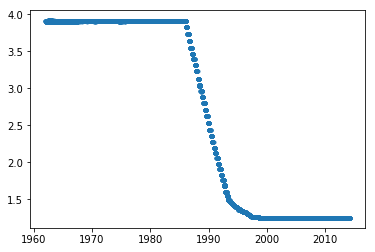

In [21]:
#discrepancy factor

price_ratio=(DF["IBM"]/IBM_yf["Close"]).dropna()
print(price_ratio)


plt.plot(price_ratio,".")

Thus, US equities is randomly adjusted and thus not suitable for investment purposes: never trust data that is given to you. Let us however try to understand were the 1.25 factor comes from: first, not from splits, since no split occurs after 2014-03-18

In [22]:
IBM.splits

Date
1964-05-18    1.25
1966-05-18    1.50
1968-04-23    2.00
1973-05-29    1.25
1979-06-01    4.00
1997-05-28    2.00
1999-05-27    2.00
Name: Stock Splits, dtype: float64

Let us compute the dividend adjustments from 2014-03-19 to the end. We must first download raw prices.

In [23]:
IBM_yf_not_adj=IBM.history("max",auto_adjust=False)

In [24]:
#compte the total adjustement due to dividends. Dividends are given in $ and are not adjusted
1/np.prod(1-(IBM.dividends["2014-03-19":]/IBM_yf_not_adj["Close"]).dropna())

1.2521608263371846

There is still a factor 1.002 to explain, but we are close. In summary, never trust a file name, column names, and never assume that the person who built a dataset was competent. 

### 6. Save as feather

Load and save in feather format is much faster than in hdf5, pickel, csv.gz, at the cost of larger files.

In [25]:
import feather   # pip install feather-format

feather.write_dataframe(r,"data/clean/us_equities_logreturns.feather")